# Serve Model

## Story
* We have a fully trained TensorFlow model
* TensorFlow models are ideal to bring them into production
* The model is stored as a computational graph and can be executed pretty much anywhere
  1. We can just load the saved model and exeute it from Python or
  1. There is a specific CC built server that can just serve it
  1. It will run in the Cloud as is
  1. Can be integrated into Java
* Even Docker can be made to have access to GPU
* Large models train very nicely, but can be unfortunate in production
  * Unfortunately, so far, only model size can be brought down, but not latency: https://github.com/tensorflow/model-optimization/issues/173
  * TFLite models do support latency speedup: https://www.tensorflow.org/model_optimization/guide/pruning/pruning_for_on_device_inference
  


In [1]:
!ls -l classifier

total 308
drwxr-xr-x 2 olli olli   4096 Oct 24 17:34 assets
-rw-r--r-- 1 olli olli  19142 Nov  5 12:24 keras_metadata.pb
-rw-r--r-- 1 olli olli 284517 Nov  5 12:24 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Nov  5 12:24 variables


## Load and use model from Python

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
# https://www.tensorflow.org/guide/keras/save_and_serialize

reconstructed_model = tf.keras.models.load_model("classifier")
reconstructed_model

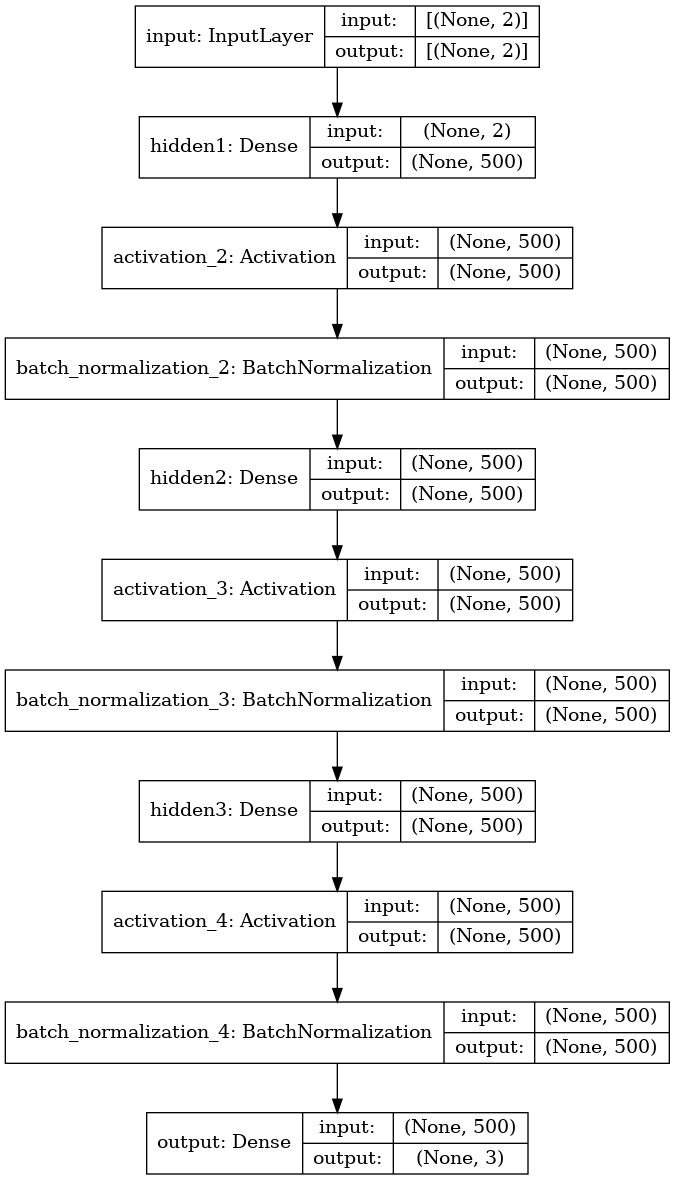

In [4]:
tf.keras.utils.plot_model(reconstructed_model, show_shapes=True)

In [71]:
%%time

reconstructed_model.predict([[48, 100]])

CPU times: user 25.9 ms, sys: 13.4 ms, total: 39.3 ms
Wall time: 36.9 ms


array([[0.02712272, 0.122238  , 0.8506393 ]], dtype=float32)

In [6]:
reconstructed_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input) at 0x7F877C710D30>})

In [7]:
inference_fn = reconstructed_model.signatures['serving_default']
inference_fn

<ConcreteFunction signature_wrapper(*, input) at 0x7F877C710D30>

In [72]:
t = tf.convert_to_tensor([[48, 100]], dtype=tf.float32)
t

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 48., 100.]], dtype=float32)>

In [81]:
%%time

reconstructed_model.predict(t)

CPU times: user 28.5 ms, sys: 1.32 ms, total: 29.8 ms
Wall time: 26.6 ms


array([[0.02712272, 0.122238  , 0.8506393 ]], dtype=float32)

In [82]:
%%time

inference_fn(input=t)

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.24 ms


{'output': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.02712272, 0.122238  , 0.8506393 ]], dtype=float32)>}

In [10]:
# * https://www.tensorflow.org/guide/intro_to_graphs
# * https://www.tensorflow.org/api_docs/python/tf/Graph#as_graph_def 

# The serialized GraphDef can be imported into another Graph (using tf.import_graph_def) or used with the C++ Session API.

graph = inference_fn.graph.as_graph_def()
type(graph)

tensorflow.core.framework.graph_pb2.GraphDef

In [11]:
graph

node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "input"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
    }
  }
}
node {
  name: "unknown"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_0"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_2"
  op: "Placeholder"
  attr {
    key: "dtype"
    val

# Optimization

* https://www.tensorflow.org/model_optimization
    * https://www.tensorflow.org/model_optimization/guide
* https://medium.com/google-cloud/optimizing-tensorflow-models-for-serving-959080e9ddbf
* https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb#scrollTo=pbY-KGMPvbW9

In [12]:
# https://www.tensorflow.org/model_optimization/guide/install
# !pip install --user --upgrade tensorflow-model-optimization

In [53]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/mlops/insurance-customers-risk-1500.csv')
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [54]:
base_model = reconstructed_model

_, baseline_model_accuracy = base_model.evaluate(X, y, verbose=0)
baseline_model_accuracy

0.7253333330154419

In [109]:
import tensorflow_model_optimization as tfmot

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(base_model)
# quantize_model = tfmot.quantization.keras.quantize_model(annotated_model)

model_for_pruning.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_hidden1  (None, 500)               2502      
_________________________________________________________________
prune_low_magnitude_activati (None, 500)               1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 500)               2001      
_________________________________________________________________
prune_low_magnitude_hidden2  (None, 500)               500502    
_________________________________________________________________
prune_low_magnitude_activati (None, 500)               1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 500)               2001      
_________________________________________________________________
prune_low_magnitude_hidden3  (None, 500)              

In [56]:
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [57]:
%%time

import tempfile

BATCH_SIZE = 32
EPOCHS = 10

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(X, y,
                  batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2,
                  callbacks=callbacks);

Epoch 1/10
38/38 [==============================] - 2s 17ms/step - loss: 0.7402 - accuracy: 0.6717 - val_loss: 0.7990 - val_accuracy: 0.6267
Epoch 2/10
38/38 [==============================] - 0s 10ms/step - loss: 0.7440 - accuracy: 0.6817 - val_loss: 0.7145 - val_accuracy: 0.6600
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 0.7189 - accuracy: 0.6875 - val_loss: 0.9931 - val_accuracy: 0.5433
Epoch 4/10
38/38 [==============================] - 0s 10ms/step - loss: 0.7273 - accuracy: 0.6675 - val_loss: 0.8263 - val_accuracy: 0.6267
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.7179 - accuracy: 0.6842 - val_loss: 0.6629 - val_accuracy: 0.7033
Epoch 6/10
38/38 [==============================] - 0s 11ms/step - loss: 0.7170 - accuracy: 0.6908 - val_loss: 0.6450 - val_accuracy: 0.7067
Epoch 7/10
38/38 [==============================] - 0s 11ms/step - loss: 0.7174 - accuracy: 0.6917 - val_loss: 0.6288 - val_accuracy: 0.7433
Epoch 8/10
38

In [58]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(X, y, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.7253333330154419
Pruned test accuracy: 0.6993333101272583


In [59]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [60]:
#docs_infra: no_execute
%tensorboard --logdir={logdir}

In [61]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
hidden3 (Dense)              (None, 500)              

In [91]:
model_for_export.save('classifier-pruned', save_format='tf', include_optimizer=False)

INFO:tensorflow:Assets written to: classifier-pruned/assets


In [92]:
!ls -l classifier/

total 308
drwxr-xr-x 2 olli olli   4096 Oct 24 17:34 assets
-rw-r--r-- 1 olli olli  19142 Nov  5 12:24 keras_metadata.pb
-rw-r--r-- 1 olli olli 284517 Nov  5 12:24 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Nov  5 12:24 variables


In [94]:
!ls -l classifier-pruned

total 264
drwxr-xr-x 2 olli olli   4096 Nov  5 13:09 assets
-rw-r--r-- 1 olli olli  18207 Nov  5 14:01 keras_metadata.pb
-rw-r--r-- 1 olli olli 237742 Nov  5 14:01 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Nov  5 14:01 variables


In [96]:
!tar czf classifier-pruned.tgz classifier-pruned/

In [98]:
# most parameters are null, as can be seen in compressed file
!ls -l *.tgz

-rw-r--r-- 1 olli olli 1207767 Nov  5 14:03 classifier-pruned.tgz
-rw-r--r-- 1 olli olli 5714201 Nov  5 12:24 classifier.tgz


## Start using Docker

- TensorFlow with Docker: https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/docker.md
- TFX Serving: https://www.tensorflow.org/tfx/serving/docker
- Complete example: https://github.com/embarced/notebooks/tree/master/tfx
- GPU support: 
  - https://www.tensorflow.org/tfx/serving/docker#serving_with_docker_using_your_gpu
  - https://github.com/NVIDIA/nvidia-docker
    - https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker
  - https://docs.docker.com/compose/gpu-support/

In [8]:
!curl -d '{"instances": [[50.0, 122.0], [48, 100], [30, 150]]}' -X POST http://localhost:8501/v1/models/insurance:predict

{
    "predictions": [[0.184337184, 0.28695032, 0.528712511], [0.0255763717, 0.198027506, 0.776396155], [0.947066486, 0.041994229, 0.0109393876]
    ]
}

## Load and use model from C++ server

https://github.com/tensorflow/serving

In [99]:
!saved_model_cli show --dir classifier-pruned --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: TensorSpec(shape=(None, 

In [100]:
!pwd

/home/olli/notebooks/mlops


In [101]:
!mkdir insurance

mkdir: cannot create directory ‘insurance’: File exists


In [102]:
!cp -R classifier-pruned/ insurance/1

In [6]:
%%bash --bg 

nohup tensorflow_model_server --port=8500 --rest_api_port=8501 \
  --model_name=insurance --model_base_path=/home/olli/notebooks/mlops/insurance  >server.log 2>&1

In [10]:
!tail server.log

2021-11-07 10:17:41.043760: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /home/olli/notebooks/mlops/insurance/1
2021-11-07 10:17:41.056323: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 78546 microseconds.
2021-11-07 10:17:41.057142: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /home/olli/notebooks/mlops/insurance/1/assets.extra/tf_serving_warmup_requests
2021-11-07 10:17:41.057625: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: insurance version: 1}
2021-11-07 10:17:41.059234: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-11-07 10:17:41.059269: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-11-07 10:17:41.059276: I tensorflow_serving/model_se